In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
import cv2
import os

In [17]:
BASE_DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'

IMAGE_FOLDER_PART1 = os.path.join(BASE_DATA_DIR, 'HAM10000_images_part_1')
IMAGE_FOLDER_PART2 = os.path.join(BASE_DATA_DIR, 'HAM10000_images_part_2')
METADATA_PATH = os.path.join(BASE_DATA_DIR, 'HAM10000_metadata.csv')

# Model parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001

In [5]:
import pandas as pd

try: 
    df = pd.read_csv(METADATA_PATH)
except:
    print("Cannot read csv")

df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_FOLDER_PART1, x + '.jpg') if os.path.exists(os.path.join(IMAGE_FOLDER_PART1, x + '.jpg')) else os.path.join(IMAGE_FOLDER_PART2, x + '.jpg'))

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['dx'])
NUM_CLASSES = len(label_encoder.classes_)
CLASS_NAMES = label_encoder.classes_
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

Number of classes: 7
Class names: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [8]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 8012
Validation samples: 2003


In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

# Create data generators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [10]:
# Tạo mô hình sử dụng ResNet50
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Đóng băng các tầng của ResNet50 để không huấn luyện lại
for layer in base_model.layers:
    layer.trainable = False

# Xây dựng mô hình
resnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Biên dịch mô hình
resnet_model.compile(optimizer='Adamax', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Tóm tắt mô hình
resnet_model.summary()

I0000 00:00:1750849684.822419      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750849684.823152      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,130,951 (92.05 MB)

 Trainable params: 566,151 (2.16 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(val_generator.samples / BATCH_SIZE)

history = resnet_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 558ms/step - accuracy: 0.7247 - loss: 0.7620 - val_accuracy: 0.7379 - val_loss: 0.7269
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 555ms/step - accuracy: 0.7080 - loss: 0.8106 - val_accuracy: 0.7354 - val_loss: 0.7196
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 551ms/step - accuracy: 0.7161 - loss: 0.7802 - val_accuracy: 0.7414 - val_loss: 0.7138
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 560ms/step - accuracy: 0.7237 - loss: 0.7405 - val_accuracy: 0.7509 - val_loss: 0.6890
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 139s 553ms/step - accuracy: 0.7289 - loss: 0.7336 - val_accuracy: 0.7499 - val_loss: 0.6942
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 138s 550ms/step - accuracy: 0.7441 - loss: 0.7185 - val_accuracy: 0.7584 - val_loss: 0.6698
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 140s 559ms/step - accuracy: 0.7498 - loss: 0.7064 - val_accuracy: 0.7639 - val_loss: 0.6684
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 141s 560ms/step - accuracy: 

In [19]:
loss, accuracy = resnet_model.evaluate(val_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.7946 - loss: 0.5900
Test Loss: 0.5502199530601501
Test Accuracy: 0.8062905669212341


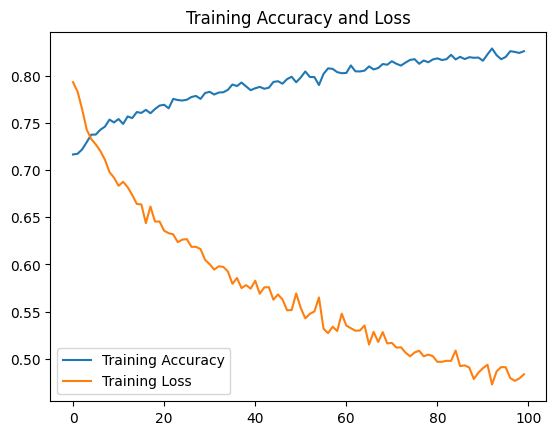

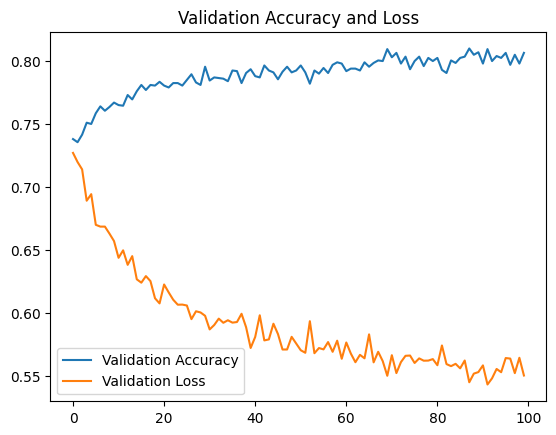

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

In [22]:
resnet_model.save('/kaggle/working/skin_disease_resnet.keras')
print("Model đã được lưu thành công.")

Model đã được lưu thành công.


In [ ]:
new_image_path = 'data3\\test\\bkl\\ISIC_0024383.jpg'
# Định nghĩa các thông số
img_width, img_height = 224, 224


def load_and_preprocess_image(img_path, img_width, img_height):
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Tải và xử lý ảnh mới
image_array = load_and_preprocess_image(new_image_path, img_width, img_height)
predictions = cnn_model.predict(image_array)

# In ra kết quả dự đoán
predicted_class = np.argmax(predictions[0])
print(predictions)
print(predicted_class)
predicted_label = class_names[predicted_class]
print(f'Dự đoán bệnh: {predicted_label}')


1/1 [==============================] - 0s 15ms/step
[[6.03111472e-09 3.25385986e-12 9.97367918e-01 3.82831719e-14
  1.17926288e-06 2.63095135e-03 1.00267855e-14]]
2
Dự đoán bệnh: bkl
